In [149]:
import numpy as np
import pandas as pd
from pyproj import Transformer
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN, KMeans, AffinityPropagation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from math import *
from matplotlib.colors import Normalize

%matplotlib inline

In [150]:
cat1 = pd.read_csv('10950_2019_9864_MOESM2_ESM.csv')
cat2 = pd.read_csv('SRL_2017007_esupp_matched_filter_cat_pawnee.csv',delimiter="\t")

# filter out everything except Pawnee
cat1 = cat1[(cat1['lat']>36.3) & (cat1['lat']<36.6) & (cat1['long']<-96.75) & (cat1['long']>-97.1)]

In [154]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
cat1[['x', 'y']] = cat1.apply(
    lambda row: transformer.transform(row['long'], row['lat']), axis=1, result_type='expand'
)
cat2[['x', 'y']] = cat2.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

df = cat2

lon_var = "long" if "long" in df.columns else "longitude"
lat_var = "lat" if "lat" in df.columns else "latitude"
df.drop_duplicates()

,day_of_the_year,cross_correlation_value,median_absolute_deviation,magnitude,latitude,longitude,event_id,year,month,day,hour,min,sec,depth,number_of_stations,decimal_year,x,y
0,1.088332,0.273,9.01,0.83,36.4251,-96.8481,2.016090e+13,2016,1,1,2,7,11,0.000,12,2016.00298,-1.078108e+07,4.359273e+06
1,1.139694,0.281,9.75,1.05,36.4286,-96.8959,2.016090e+13,2016,1,1,3,21,9,0.000,11,2016.00312,-1.078640e+07,4.359757e+06
2,1.178318,0.270,9.06,1.37,36.4212,-96.8336,2.016090e+13,2016,1,1,4,16,46,0.000,10,2016.00323,-1.077947e+07,4.358734e+06
3,1.224289,0.276,9.26,0.90,36.4618,-96.8404,2.016090e+13,2016,1,1,5,22,58,0.000,12,2016.00335,-1.078022e+07,4.364352e+06
4,1.325696,0.287,9.60,1.07,36.4308,-96.8922,2.016091e+13,2016,1,1,7,49,0,0.000,12,2016.00363,-1.078599e+07,4.360062e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4668,343.710403,0.271,9.27,1.35,36.4415,-96.8187,2.016090e+13,2016,12,8,17,2,58,65.991,11,2016.94167,-1.077781e+07,4.361542e+06
4669,343.739186,0.274,9.82,0.77,36.4308,-96.8922,2.016091e+13,2016,12,8,17,44,25,0.000,12,2016.94175,-1.078599e+07,4.360062e+06
4670,343.769458,0.247,9.30,1.09,36.3835,-96.9274,2.016093e+13,2016,12,8,18,28,1,0.000,14,2016.94183,-1.078991e+07,4.353520e+06
4671,343.809269,0.273,9.76,0.93,36.4170,-96.8628,2.016090e+13,2016,12,8,19,25,20,0.000,12,2016.94194,-1.078272e+07,4.358153e+06


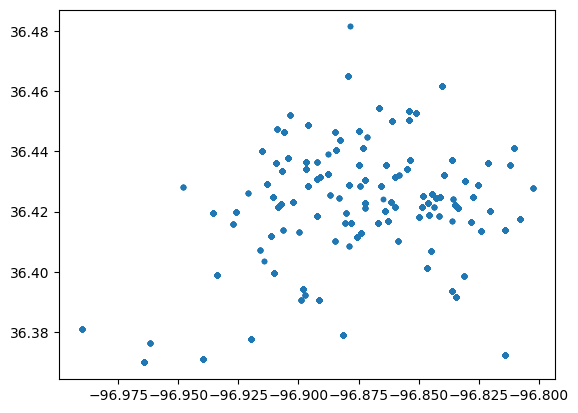

In [155]:
# Outlier removal
z_thres = 3.0
z_scores = (df - df.mean())/df.std()
outliers = (z_scores.abs() > z_thres).any(axis=1)
df_cleaned = df[~outliers]

# plot xy
plt.plot(df_cleaned[lon_var],df_cleaned[lat_var],'.')
plt.show()


C:\Users\archo\AppData\Local\Temp\ipykernel_2124\2063493299.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['cluster'] = cluster_labels


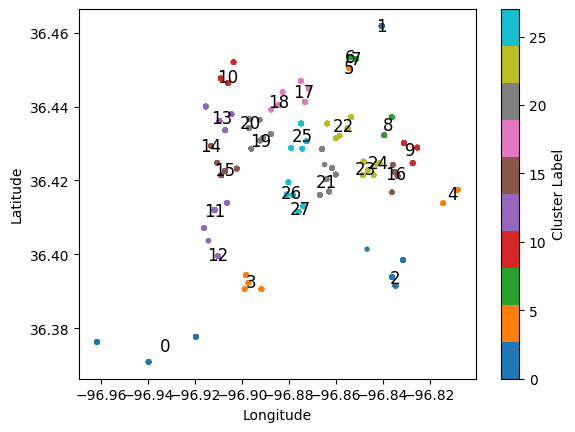

[{0, 2, 3, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27}]


In [156]:
# HDBSCAN and KNN clustering


X = df_cleaned[[lat_var,lon_var]]

method = "hdb" # <---------------------------- CHANGE THIS TO USE DIFFERENT CLUSTERING METHOD
if method == "hdb":
    hdb = HDBSCAN(min_cluster_size=60)
    cluster_labels = hdb.fit_predict(X)
elif method=="kmn":
    kmeans = KMeans(n_clusters=10)
    cluster_labels = kmeans.fit_predict(X)
elif method=="afp":
    affinityp = AffinityPropagation()
    cluster_labels = affinityp.fit_predict(X)
mask = cluster_labels!=-1

include_noise = False # <---------------------- CHANGE THIS TO INCLUDE ALL EARTHQUAKES

if include_noise:
    X_train = X[mask]
    y_train = cluster_labels[mask]
    X_noise = X[not mask]

    knn = KNeighborsClassifier(n_neighbors=90)
    knn.fit(X_train, y_train)

    if not X_noise.empty:
        noise_labels = knn.predict(X_noise)
        cluster_labels[not mask] = noise_labels

df_cleaned['cluster'] = cluster_labels

df_cleaned = df_cleaned[df_cleaned['cluster']!=-1]
centroids = df_cleaned.groupby('cluster')[[lat_var, lon_var]].mean()

for cluster, centroid in centroids.iterrows():
    plt.text(centroid[lon_var], centroid[lat_var], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned[lon_var], df_cleaned[lat_var], c=df_cleaned['cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Merge clusters based on distance threshold
threshold = 0.1  # Define a threshold for merging clusters
groups = []
visited = set()

for i, centroid1 in centroids.iterrows():
    if i in visited:
        continue
    group = {i}
    for j, centroid2 in centroids.iterrows():
        if i != j:
            dist = sqrt((centroid1[lon_var] - centroid2[lon_var])**2 +
                        (centroid1[lat_var] - centroid2[lat_var])**2)
            if dist < threshold:
                group.add(j)
                visited.add(j)
    groups.append(group)


print(groups)

df_cleaned.to_csv('cleaned_skoulam_2020_clustered.csv')


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}


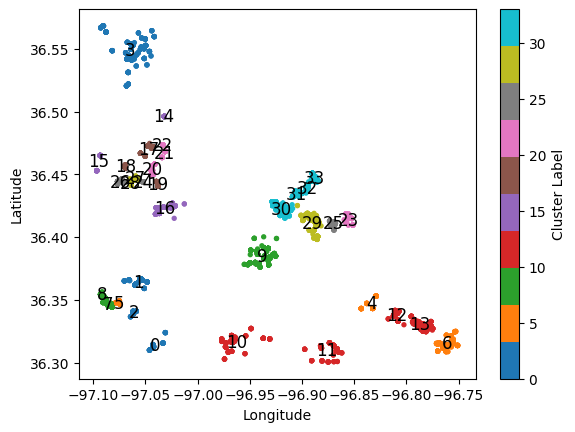

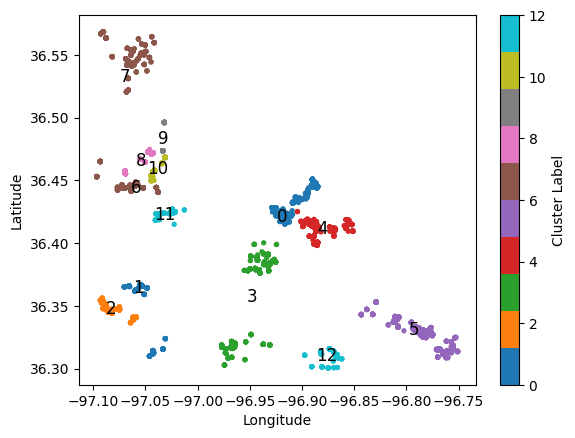

In [146]:
# Preferred groups from manual checking
%matplotlib inline
df_cleaned = pd.read_csv('cleaned_skoulam_2020_clustered.csv')
print(set(df_cleaned['cluster']))
df_cleaned = df_cleaned[df_cleaned['cluster']!=-1]
centroids = df_cleaned.groupby('cluster')[['lat', 'long']].mean()


for cluster, centroid in centroids.iterrows():
    plt.text(centroid['long'], centroid['lat'], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


groups = [{0,30,31,32,33},{1},{8,7,5,2},{10,9},{25,23,29},{6,12,13,4},{26,28,27,24,19},{3,15},{18,17},{14,22},{20,21},{16},{11}]

cluster_mapping = {}

for new_label, group in enumerate(groups):
    for old_label in group:
        cluster_mapping[old_label] = new_label

df_cleaned['merged_cluster'] = df_cleaned['cluster'].map(cluster_mapping)


centroids = df_cleaned.groupby('merged_cluster')[['lat', 'long']].mean()


for cluster, centroid in centroids.iterrows():
    plt.text(centroid['long'], centroid['lat'], str(cluster), fontsize=12, ha='center', va='center', color='black')

plt.scatter(df_cleaned['long'], df_cleaned['lat'], c=df_cleaned['merged_cluster'], cmap='tab10', s=8)
plt.colorbar(label='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [148]:
%matplotlib qt
cmap = plt.get_cmap('tab10')
norm = Normalize(vmin=df_cleaned['merged_cluster'].min(), vmax=df_cleaned['merged_cluster'].max())

depth_norm = Normalize(vmin=df_cleaned['depth'].min(), vmax=df_cleaned['depth'].max())
alpha_values = depth_norm(df_cleaned['depth'])

plt.scatter(
    df_cleaned['long'], 
    df_cleaned['lat'], 
    c=df_cleaned['merged_cluster'], 
    cmap='tab10', 
    s=2,
    alpha=alpha_values
)
plt.colorbar(label='Cluster Label')

cluster_type = "merged_cluster"
for cluster in df_cleaned[cluster_type].unique():
    print(cluster)
    cluster_data = df_cleaned[df_cleaned[cluster_type] == cluster]
    X = cluster_data['long'].values.reshape(-1, 1)
    y = cluster_data['lat'].values
    model = LinearRegression()
    model.fit(X, y)

    x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_vals = model.predict(x_vals)

    cluster_color = cmap(norm(cluster))
    
    plt.plot(x_vals, y_vals, label=f'Cluster {cluster} Line', color=cluster_color)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


4
3
12
6
10
8
9
2
7
1
5
0
11
